In [3]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal, Annotated
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage
import operator
from pydantic import BaseModel, Field


In [4]:
generator_llm = ChatOpenAI(model='gpt-4o-mini')
evaluator_llm = ChatOpenAI(model='gpt-4o-mini')
optimizer_llm = ChatOpenAI(model='gpt-4o-mini')

In [5]:
class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

In [6]:
structured_evaluator_llm = evaluator_llm.with_structured_output(TweetEvaluation)

In [7]:
# state
class TweetState(TypedDict):

    topic: str
    tweet: str
    evaluation: Literal["approved", "needs_improvement"]
    feedback: str
    iteration: int
    max_iteration: int

    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]

In [8]:
def generate_tweet(state: TweetState):

    # prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]

    # send generator_llm
    response = generator_llm.invoke(messages).content

    # return response
    return {'tweet': response, 'tweet_history': [response]}

In [9]:
def evaluate_tweet(state: TweetState):

    # prompt
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]

    response = structured_evaluator_llm.invoke(messages)

    return {'evaluation':response.evaluation, 'feedback': response.feedback, 'feedback_history': [response.feedback]}

In [10]:
def optimize_tweet(state: TweetState):

    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]

    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration'] + 1

    return {'tweet': response, 'iteration': iteration, 'tweet_history': [response]}

In [11]:
def route_evaluation(state: TweetState):

    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

In [16]:
graph = StateGraph(TweetState)

graph.add_node('generate', generate_tweet)
graph.add_node('evaluate', evaluate_tweet)
graph.add_node('optimize', optimize_tweet)


graph.add_edge(START, 'generate')
graph.add_edge('generate', 'evaluate')
graph.add_conditional_edges('evaluate',route_evaluation,{'approved': END, 'needs_improvement': 'optimize'})
graph.add_edge('optimize','evaluate')

workflow = graph.compile()


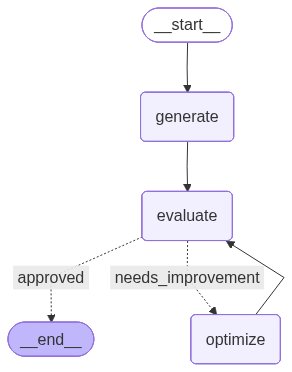

In [17]:
workflow

In [18]:
initial_state = {
    "topic": "qwerabc",
    "iteration": 1,
    "max_iteration": 5
}
result = workflow.invoke(initial_state)

In [19]:
result

{'topic': 'qwerabc',
 'tweet': '"Introducing \'qwerabc\': the passcode of one-handed legends! ☕️✨ Because conquering life means juggling coffee in one hand and *absolutely nothing* in the other. Who says you can\'t do it all? #OneHandWonder #LegendaryMultitasking"',
 'evaluation': 'needs_improvement',
 'feedback': "The tweet attempts to poke fun at multitasking with a playful tone, but it lacks originality as the concept of juggling coffee while doing tasks is cliché in the social media landscape. While there are light humorous elements, it doesn't deliver a strong punchline or a unique twist to be genuinely funny. The overall flow is a bit wordy, making it less punchy and less likely to captivate readers quickly. The hashtags add a bit of flavor, but the humor doesn't feel fresh enough to encourage widespread sharing.",
 'iteration': 5,
 'max_iteration': 5,
 'tweet_history': ['Just discovered that "qwerabc" is the secret code for all the keyboard warriors who think typing with one han

In [20]:
for tweet in result['tweet_history']:
    print(tweet)

Just discovered that "qwerabc" is the secret code for all the keyboard warriors who think typing with one hand while sipping coffee qualifies as multitasking. 🖥️☕️ #TechSavvy #CaffeinatedChaos
"Just found out 'qwerabc' is the top-secret passcode for all the one-handed keyboard warriors. Sipping coffee while typing counts as 'multitasking,' right? 😂💻☕️ #KeyboardNinja #CaffeineFiction"
"Turns out 'qwerabc' is the go-to passcode for one-handed keyboard wizards! Who needs two hands when you can master multitasking with just a coffee and a dream? ☕️💻 #KeyboardNinja #CaffeineConqueror"
"Officially declaring 'qwerabc' as the passcode of the one-handed legends. Who knew mastering multitasking meant balancing coffee in one hand and destiny in the other? ☕️✨ #OneHandWonder #CoffeeAndConquer"
"Introducing 'qwerabc': the passcode of one-handed legends! ☕️✨ Because conquering life means juggling coffee in one hand and *absolutely nothing* in the other. Who says you can't do it all? #OneHandWonder #